# Examples

## Run on real world data

You can get [Frank Moosmann's "Velodyne SLAM" Dataset](https://www.mrt.kit.edu/z/publ/download/velodyneslam/dataset.html) by following the instructions [in the original repository's README](https://github.com/PRBonn/depth_clustering#run-on-real-world-data):

```sh
$ mkdir data/; wget http://www.mrt.kit.edu/z/publ/download/velodyneslam/data/scenario1.zip -O data/moosmann.zip; unzip data/moosmann.zip -d data/; rm data/moosmann.zip
```

Since those unzipped PNGs could not be read with PIL, we will use the [imageio](https://pypi.org/project/imageio/) library instead. You can install it with the following:

```sh
$ pip install -U imageio
```

In [1]:
import imageio.v3 as iio

filename = "data/scenario1/scan00001.png"
input_image = iio.imread(filename)
input_image.shape

(64, 870)

In [2]:
input_image

array([[12251, 12417, 12992, ..., 11855, 11965, 12003],
       [12190, 12364, 12917, ..., 11809, 11942, 12020],
       [12279, 12449, 12976, ..., 11819, 11946, 12022],
       ...,
       [    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0]], dtype=int32)

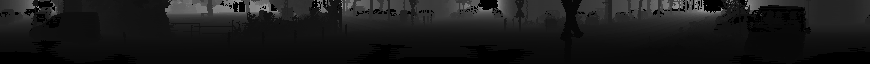

In [3]:
from IPython.display import Image
Image(filename)

To convert the pixel values to meters, just divide by 500 as described in `data/scenario1/DATAFORMAT.txt`.

In [4]:
input_image = input_image / 500.
input_image

array([[24.502, 24.834, 25.984, ..., 23.71 , 23.93 , 24.006],
       [24.38 , 24.728, 25.834, ..., 23.618, 23.884, 24.04 ],
       [24.558, 24.898, 25.952, ..., 23.638, 23.892, 24.044],
       ...,
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ]])

Also, you need to convert input image dtype to `float32`.

In [5]:
input_image.dtype

dtype('float64')

In [6]:
depth_image = input_image.astype("float32")

## Run Depth Clustering algorithm

First, we define our LiDAR projection parameters:

In [7]:
from math import radians

from depth_clustering import SpanParams, ProjectionParams

h_span_params = SpanParams(radians(-180), radians(180), num_beams=870)
v_span_params = SpanParams(radians(-24), radians(2), num_beams=64)
params = ProjectionParams(h_span_params, v_span_params)

We run the Depth Clustering algorithm for the image. You can do this with the `compute_labels` function:

In [8]:
%%time
from depth_clustering import compute_labels

raw_label_image = compute_labels(
    depth_image, params, angle_threshold=radians(10.0)
)
raw_label_image

CPU times: user 1.24 s, sys: 23.6 ms, total: 1.26 s
Wall time: 1.26 s


array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

Now you can obtain `raw_label_image`, a label matrix of the `depth_image`.

Notice that the first run of `compute_labels` takes much time to translate the function to optimized machine code with [Numba](https://numba.pydata.org/). However, rerun it, and you will see it runs faster than the first time.

In [9]:
%%time
angle_threshold = radians(10.0)

for _ in range(100):
    raw_label_image = compute_labels(
        depth_image, params, angle_threshold
    )

CPU times: user 4.39 s, sys: 69.6 ms, total: 4.46 s
Wall time: 4.45 s


Let's color the matrix:

In [12]:
import matplotlib.pyplot as plt

# If you can't change figsize, then run this block again
plt.rcParams['figure.figsize'] = [16, 8]

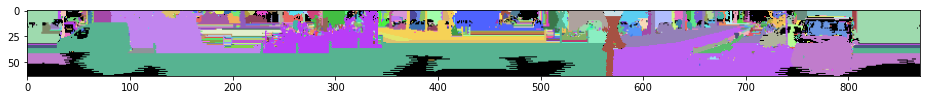

In [13]:
import numpy as np
from matplotlib.pyplot import imshow
from PIL import Image

def color_label(mat):
    # Paint the output labels matrix with some random colors
    r = (mat > 0) * ((mat * 29 +  73) % 200 + 56)
    g = (mat > 0) * ((mat * 61 + 101) % 200 + 56)
    b = (mat > 0) * ((mat * 71 +  47) % 200 + 56)
    return np.stack([r, g, b], axis=-1).astype("uint8")

imshow(Image.fromarray(color_label(raw_label_image)))

There are too large or too small clusters, so we remove them:

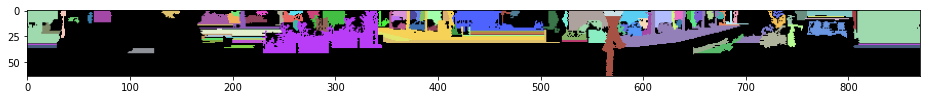

In [14]:
from depth_clustering import filter_clusters

label_image = filter_clusters(
    raw_label_image,
    min_cluster_size=35,
    max_cluster_size=3000,
)

imshow(Image.fromarray(color_label(label_image)))

Currently, we haven't implemented the `DepthGroundRemover` function, but we plan to implement it in the future.

## AngleDiff

We can also calculate the angle difference of the image for reference.

You can skip this step if you only want to calculate the clusters. 

In [15]:
from depth_clustering import AngleDiff

angle_diff = AngleDiff(depth_image, params)
mat = angle_diff.visualize()

mat.shape

(64, 870, 3)

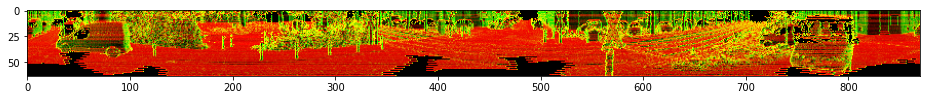

In [16]:
im = Image.fromarray(mat)
imshow(im)